In [1]:
import sys
sys.path.append('../')

import numpy as np
from cube import Cube
from tqdm import tqdm
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from value_policy_net import ValuePolicyNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
k = 5
l = 1000
M = 100

lr = 1e-3
batch_len = 32

In [3]:
action_encode = {
    'F': 0,
    'F\'': 1,
    'B' : 2,
    'B\'': 3,
    'L' : 4,
    'L\'': 5,
    'R' : 6,
    'R\'': 7,
    'U' : 8,
    'U\'': 9,
    'D' : 10,
    'D\'': 11,
}
action_decode = {encoding : action for action, encoding in action_encode.items()}

In [4]:
vp_net = ValuePolicyNet().to(device)
optim = torch.optim.RMSprop(vp_net.parameters(), lr = lr)
criterion = torch.nn.MSELoss()

In [5]:
def encode_state(tracked, edges, corners):
    encoded = np.zeros((20, 24))
    for f in range(6):
        for i in range(3):
            for j in range(3):
                is_edge = (i == 1) or (j == 1)
                if tracked[f, i, j] != -1:
                    pos_value = edges[f, i, j] if is_edge else corners[f, i, j]
                    encoded[tracked[f, i, j], pos_value] = 1
    
    return encoded

def get_scrambled_cubes(k, l):
    states = []
    for _ in range(l):
        cube = Cube()
        scramble_str = cube.get_scramble(k)
        for rot_num, rot_code in enumerate(scramble_str.split(' ')):
            cube.rotate_code(rot_code)
            states.append((np.copy(cube.facelets), np.copy(cube.tracked), rot_num + 1))
    
    return states

def batchify(X, Y, W, batch_size):
    x_batch = []
    y_v_batch = []
    y_p_batch = []
    w_batch = []
    for x, (y_v, y_p), w in zip(X, Y, W):
        x_batch.append(x)
        y_v_batch.append(y_v)
        y_p_batch.append(y_p)
        w_batch.append(w)
        if len(x_batch) >= batch_size:
            yield torch.Tensor(np.array(x_batch)).to(device), torch.Tensor(y_v_batch).to(device), torch.Tensor(y_p_batch).to(device), torch.Tensor(w_batch).to(device)
            x_batch.clear()
            y_v_batch.clear()
            y_p_batch.clear()
            w_batch.clear()
    if len(x_batch) > 0:
        yield torch.Tensor(np.array(x_batch)).to(device), torch.Tensor(y_v_batch).to(device), torch.Tensor(y_p_batch).to(device), torch.Tensor(w_batch).to(device)
    return None

In [6]:
losses = []
for it in range(M):
    cube = Cube()
    scrambled_cubes = get_scrambled_cubes(k, l)
    S = [f for f, _, _ in scrambled_cubes]
    W = [1 / n for _, _, n in scrambled_cubes]
    X = [encode_state(t, cube.edges, cube.corners) for _, t, _ in scrambled_cubes]
    Y = []
    
    for s, x in zip(S, X):
        v_x = []
        p_x = []
        r_x = []
        solved = []
        for a in range(12):
            with torch.no_grad():
                v_x_a, p_x_a = vp_net(torch.Tensor(x)[None, :].to(device))
                v_x_a = v_x_a[0]
                p_x_a = p_x_a[0]
            cube.facelets = np.copy(s)
            r_x_a = cube.rotate_code_get_reward(action_decode[a], 'deepcube')
            solved.append(cube.is_solved())
            
            v_x.append(v_x_a)
            p_x.append(p_x_a)
            r_x.append(r_x_a)
        
        v_x = torch.Tensor(v_x)
        p_x = torch.stack(p_x)
        r_x = torch.Tensor(r_x)
        
        v_next = r_x + v_x
        for a in range(12):
            if solved[a]:
                v_next[a] = r_x[a]
        
        y_v = torch.max(v_next)
        y_p = torch.argmax(v_next)
        Y.append((y_v, y_p))

    #TODO: maybe shuffle samples
    it_losses = []
    for x_batch, y_v_batch, y_p_batch, w_batch in batchify(X, Y, W, batch_len):
        optim.zero_grad()
        y_v_pred, y_p_pred = vp_net(x_batch)
        v_loss = torch.mean(w_batch * (y_v_batch - y_v_pred) ** 2)
        p_loss = torch.mean(w_batch * torch.nn.CrossEntropyLoss(reduction = 'none')(y_p_pred, y_p_batch.long()))
        loss = v_loss + p_loss
        loss.backward()
        optim.step()
        
        it_losses.append(loss.item())
    it_loss = np.mean(it_losses)
    losses.append(it_loss)
    
    print(f'Iteration {it}: loss = {it_loss}')

Iteration 0: loss = 2363.966833976803
Iteration 1: loss = 2.191170187892428
Iteration 2: loss = 1.9889680492650172
Iteration 3: loss = 1.7800843275276719
Iteration 4: loss = 2.127574428631242
Iteration 5: loss = 1.3147729984514274
Iteration 6: loss = 1.3243441194485708
Iteration 7: loss = 1.1274102671890502
Iteration 8: loss = 1.4971369793460627
Iteration 9: loss = 1.717337296267224
Iteration 10: loss = 1.8250023327815306
Iteration 11: loss = 2.4471366929400498
Iteration 12: loss = 15.479933805526441
Iteration 13: loss = 1.6185516126596244
Iteration 14: loss = 1.361502428722989
Iteration 15: loss = 1.8626959828814125
Iteration 16: loss = 1.3744172150162375
Iteration 17: loss = 1.6938751567700865
Iteration 18: loss = 2.3208840060385927
Iteration 19: loss = 1.9263419603845875
Iteration 20: loss = 1.8149584023056515
Iteration 21: loss = 2.228033358124411
Iteration 22: loss = 1.7873213070972709
Iteration 23: loss = 1.584371943762348
Iteration 24: loss = 1.2477153433356316
Iteration 25: los

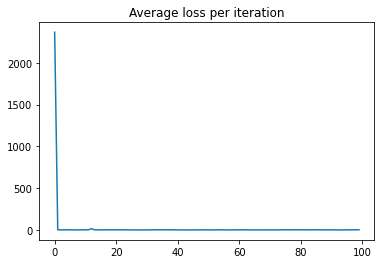

In [7]:
plt.plot(losses)
plt.title('Average loss per iteration')
plt.show()

In [8]:
torch.save(vp_net.state_dict(), 'vp_net.pt')